In [1]:
from preamble import *

%config InlineBackend.figure_format = 'retina'
%load_ext lab_black

In [2]:
# dill.load_session("Sim_Cyclical_Poisson.pkl")

In [3]:
import sys, pandas

print("ABC version:", abc.__version__)
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)
print("Arviz version:", arviz.__version__)
print("Pandas version:", pandas.__version__)

tic()

ABC version: 0.1.0
Python version: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Numpy version: 1.20.3
PyMC3 version: 3.11.2
Arviz version: 0.11.2
Pandas version: 1.2.4


In [4]:
numIters = 10
popSize = 1000
smcArgs = {"verbose": True, "numProcs": 40}

# Time dependent: nonhomogenous Poisson process with seasonality

The claim arrival process is governed by a non homogenous Poisson process $N_t$ with intensity function 

$$
\lambda(t) = b[\sin(2\pi c t) + 1]
$$

The claim frequency data $n_s,\,s = 1,\ldots, t$ correspond to the increments of this non homogeneous Poisson process. These are independent Poisson variables $\text{Pois}[\mu(s)]$ with 

$$
\mu(s) = \int_{s-1}^s\lambda(u)du = b + \frac{b}{2\pi c}\left[\cos(2\pi(s-1) c) - \cos(2\pi s c)\right],\quad s = 1,\ldots, t
$$



In [5]:
rg = default_rng(123)
sample_sizes = [50, 250]
T = sample_sizes[-1]

a, b, c, μ, σ = 1, 5, 1 / 50, 0, 0.5

θ_True = a, b, c, μ, σ

freq, sev, theta = "cyclical_poisson", "lognormal", [a, b, c, μ, σ]

freqs, sevs = abc.simulate_claim_data(rg, T, freq, sev, theta)

# Aggregation process
psi = abc.Psi("sum")

xData = abc.compute_psi(freqs, sevs, psi)

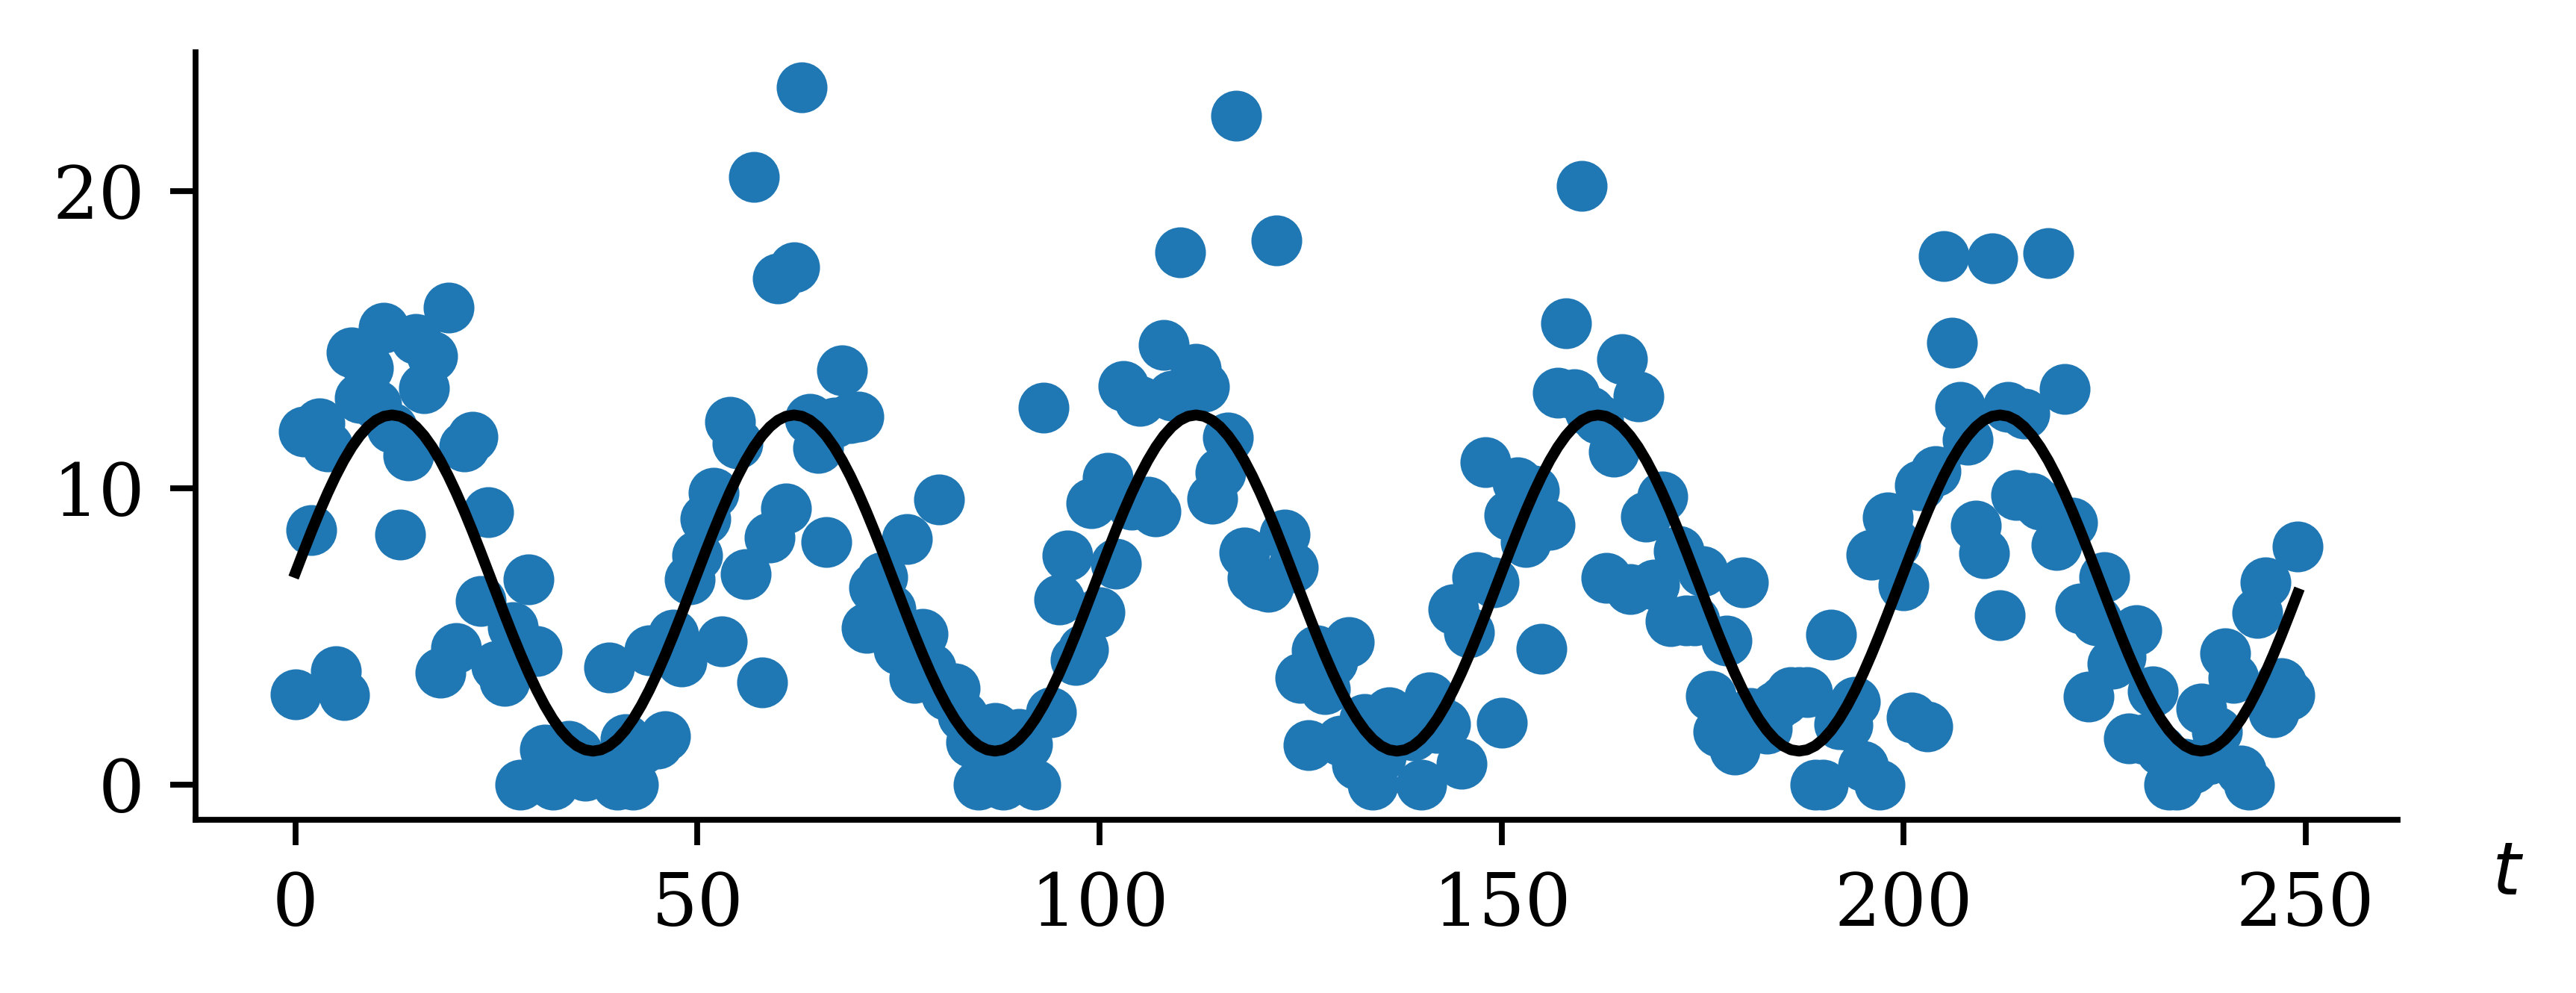

In [6]:
t = np.arange(T)
mus = (
    a
    + b
    + b * (np.cos(2 * np.pi * t * c) - np.cos(2 * np.pi * (t + 1) * c)) / 2 / np.pi / c
)
expXs = np.exp(μ + σ ** 2 / 2) * mus
# expXs = μ * mus

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(t, expXs, label="Expected value for $x_s$", c="k")
ax.scatter(t, xData, label="Observed $x_s$")
ax.set(xlabel="$t$", title="")
ax.xaxis.set_label_coords(1.05, -0.025)
# ax.grid()
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(
#     handles, labels, ncol=2, borderaxespad=-0.5, loc="lower center", frameon=False
# )
sns.despine()
save_cropped("../Figures/cyclical_poisson_lognormal_data.pdf")

In [7]:
params = ("a", "b", "c", "\mu", "\sigma")
prior = abc.IndependentUniformPrior(
    [(0, 50), (0, 50), (1 / 1000, 1 / 10), (-10, 10), (0, 3)]
)
model = abc.Model("cyclical_poisson", "lognormal", psi, prior)

# ABC posterior when exactly matching the time indices

In [8]:
%%time 
AR = 2
dfABC = pd.DataFrame()

for ss in sample_sizes:
    xDataSS = xData[:ss]

    #scale_x = 100
    #scale_t = scale_x * (np.max(xData) - np.min(xData)) / (ss - 1) * AR
    gamma = (np.max(xDataSS) - np.min(xDataSS)) / (ss - 1) * AR


    %time fit1 = abc.smc(numIters, popSize, xDataSS, model, sumstats=abc.identity, **smcArgs)
    %time fit2 = abc.smc(numIters, popSize, xDataSS, model, sumstats=abc.wrap_ss_curve_matching(gamma),\
                          distance=abc.wass_2Ddist, **smcArgs)
    %time fit3 = abc.smc(numIters, popSize, xDataSS, model, **smcArgs)
    fits = (fit1,fit2, fit3)

    
    distances = ["L1", "curve_matching", "sorted_data"]
    for k, fit in enumerate(fits):

        columns = {
            "ss": np.repeat(ss, popSize),
            "weights": fit.weights,
            "distance": np.repeat(distances[k], popSize),
        }

        for i, param in enumerate(params):
            columns[param] = fit.samples[:, i]

        res = pd.DataFrame(columns)

        dfABC = pd.concat([dfABC, res])

Final population dists <= 2.51, ESS = 793
CPU times: user 13.8 s, sys: 2.01 s, total: 15.8 s
Wall time: 43.1 s


Final population dists <= 1.77, ESS = 805
CPU times: user 14.2 s, sys: 923 ms, total: 15.1 s
Wall time: 34.9 s


Final population dists <= 0.76, ESS = 732
CPU times: user 15.1 s, sys: 1.05 s, total: 16.1 s
Wall time: 41.4 s


Final population dists <= 3.25, ESS = 844
CPU times: user 15.1 s, sys: 1.08 s, total: 16.1 s
Wall time: 1min 30s


Final population dists <= 1.73, ESS = 593
CPU times: user 24.7 s, sys: 1.41 s, total: 26.1 s
Wall time: 2min 23s


Final population dists <= 0.35, ESS = 569
CPU times: user 16.8 s, sys: 1.2 s, total: 18 s
Wall time: 1min 33s
CPU times: user 1min 39s, sys: 7.67 s, total: 1min 47s
Wall time: 7min 26s


# Plots to compare the posterior distribution based on different distance for a given sample size

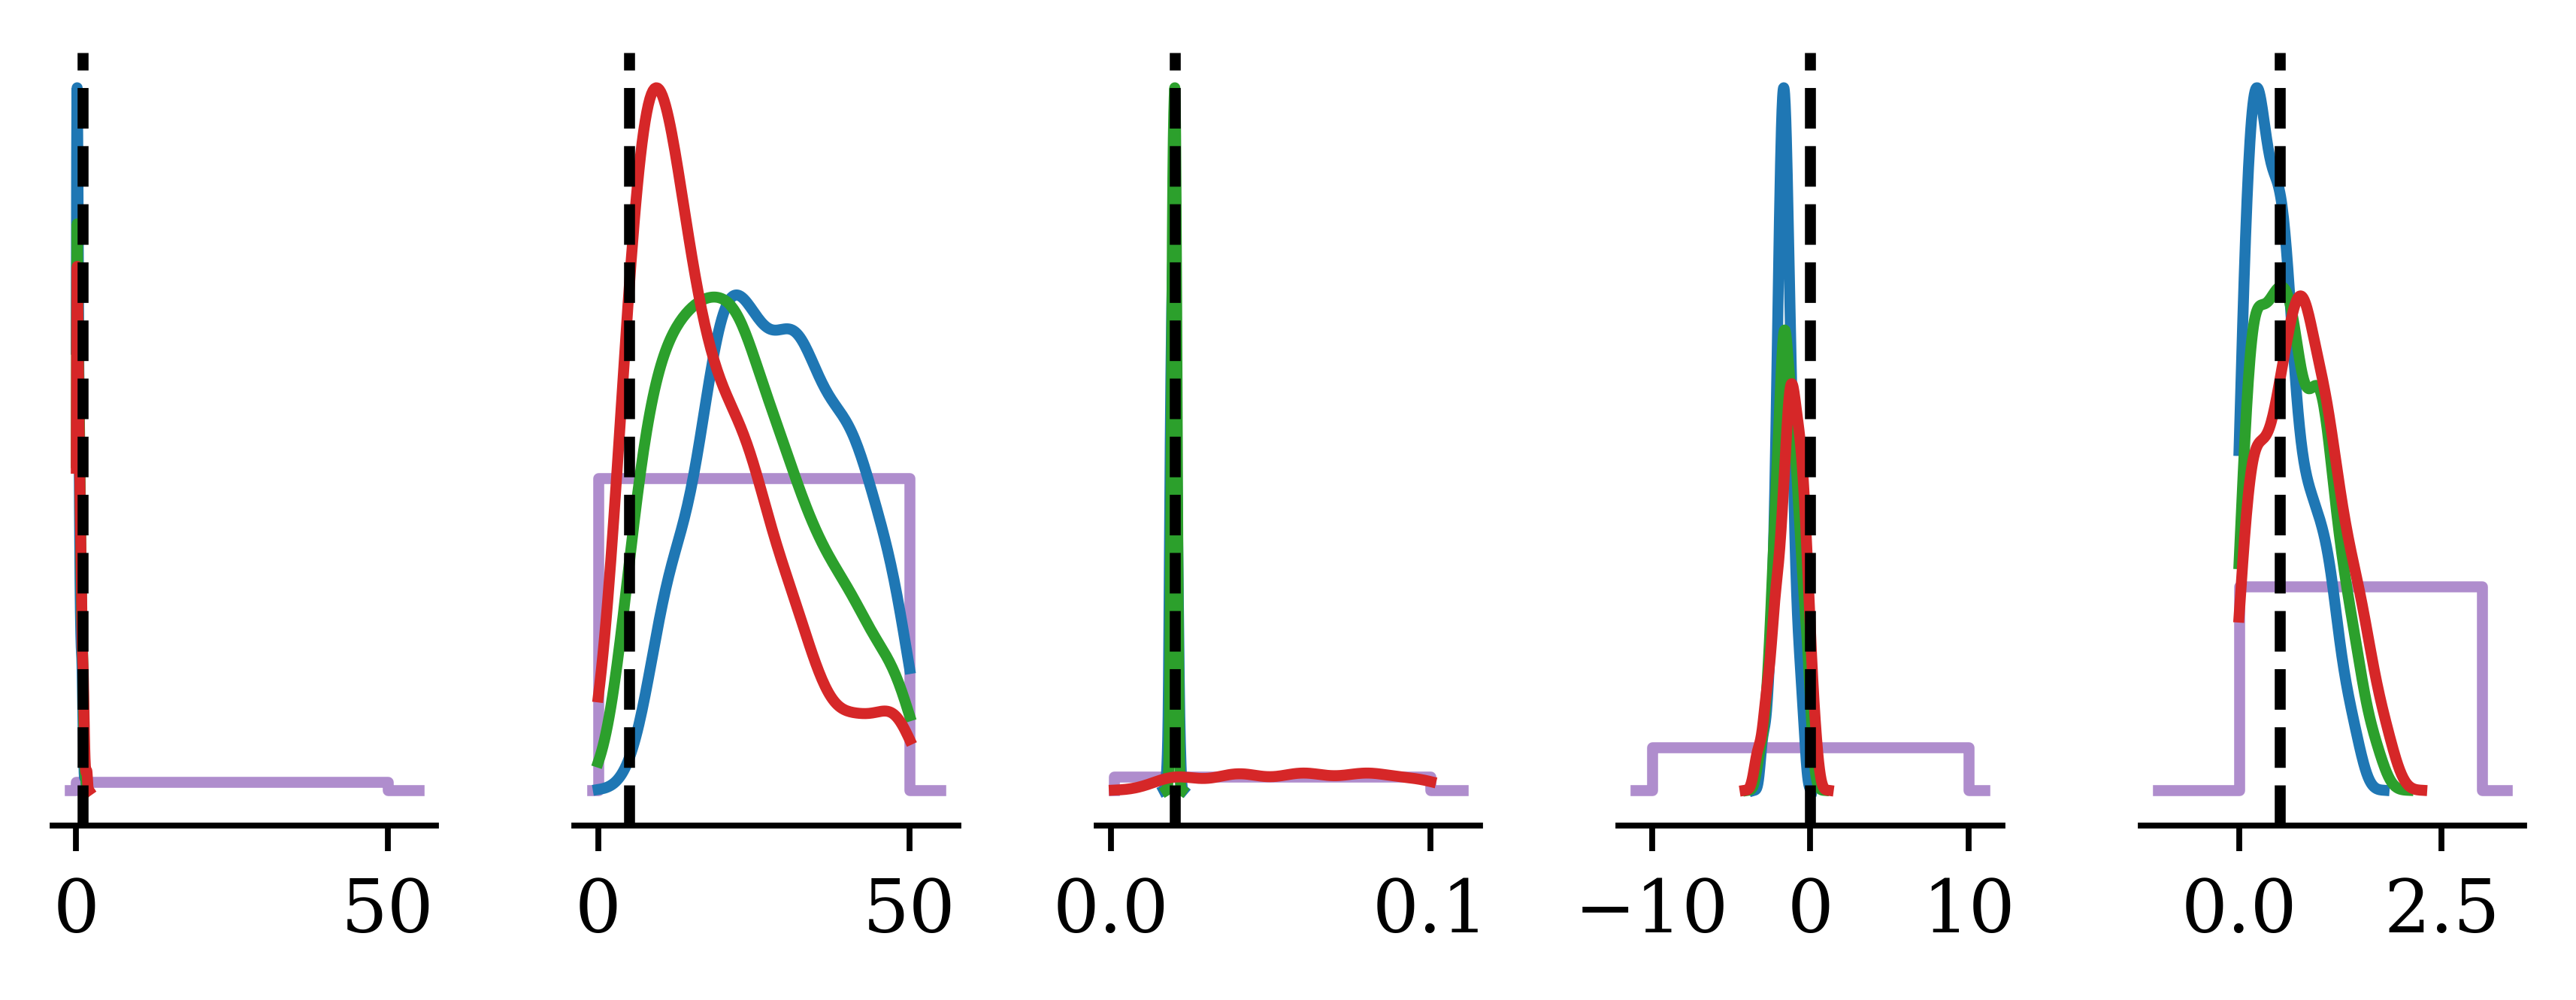

<Figure size 1750x700 with 0 Axes>

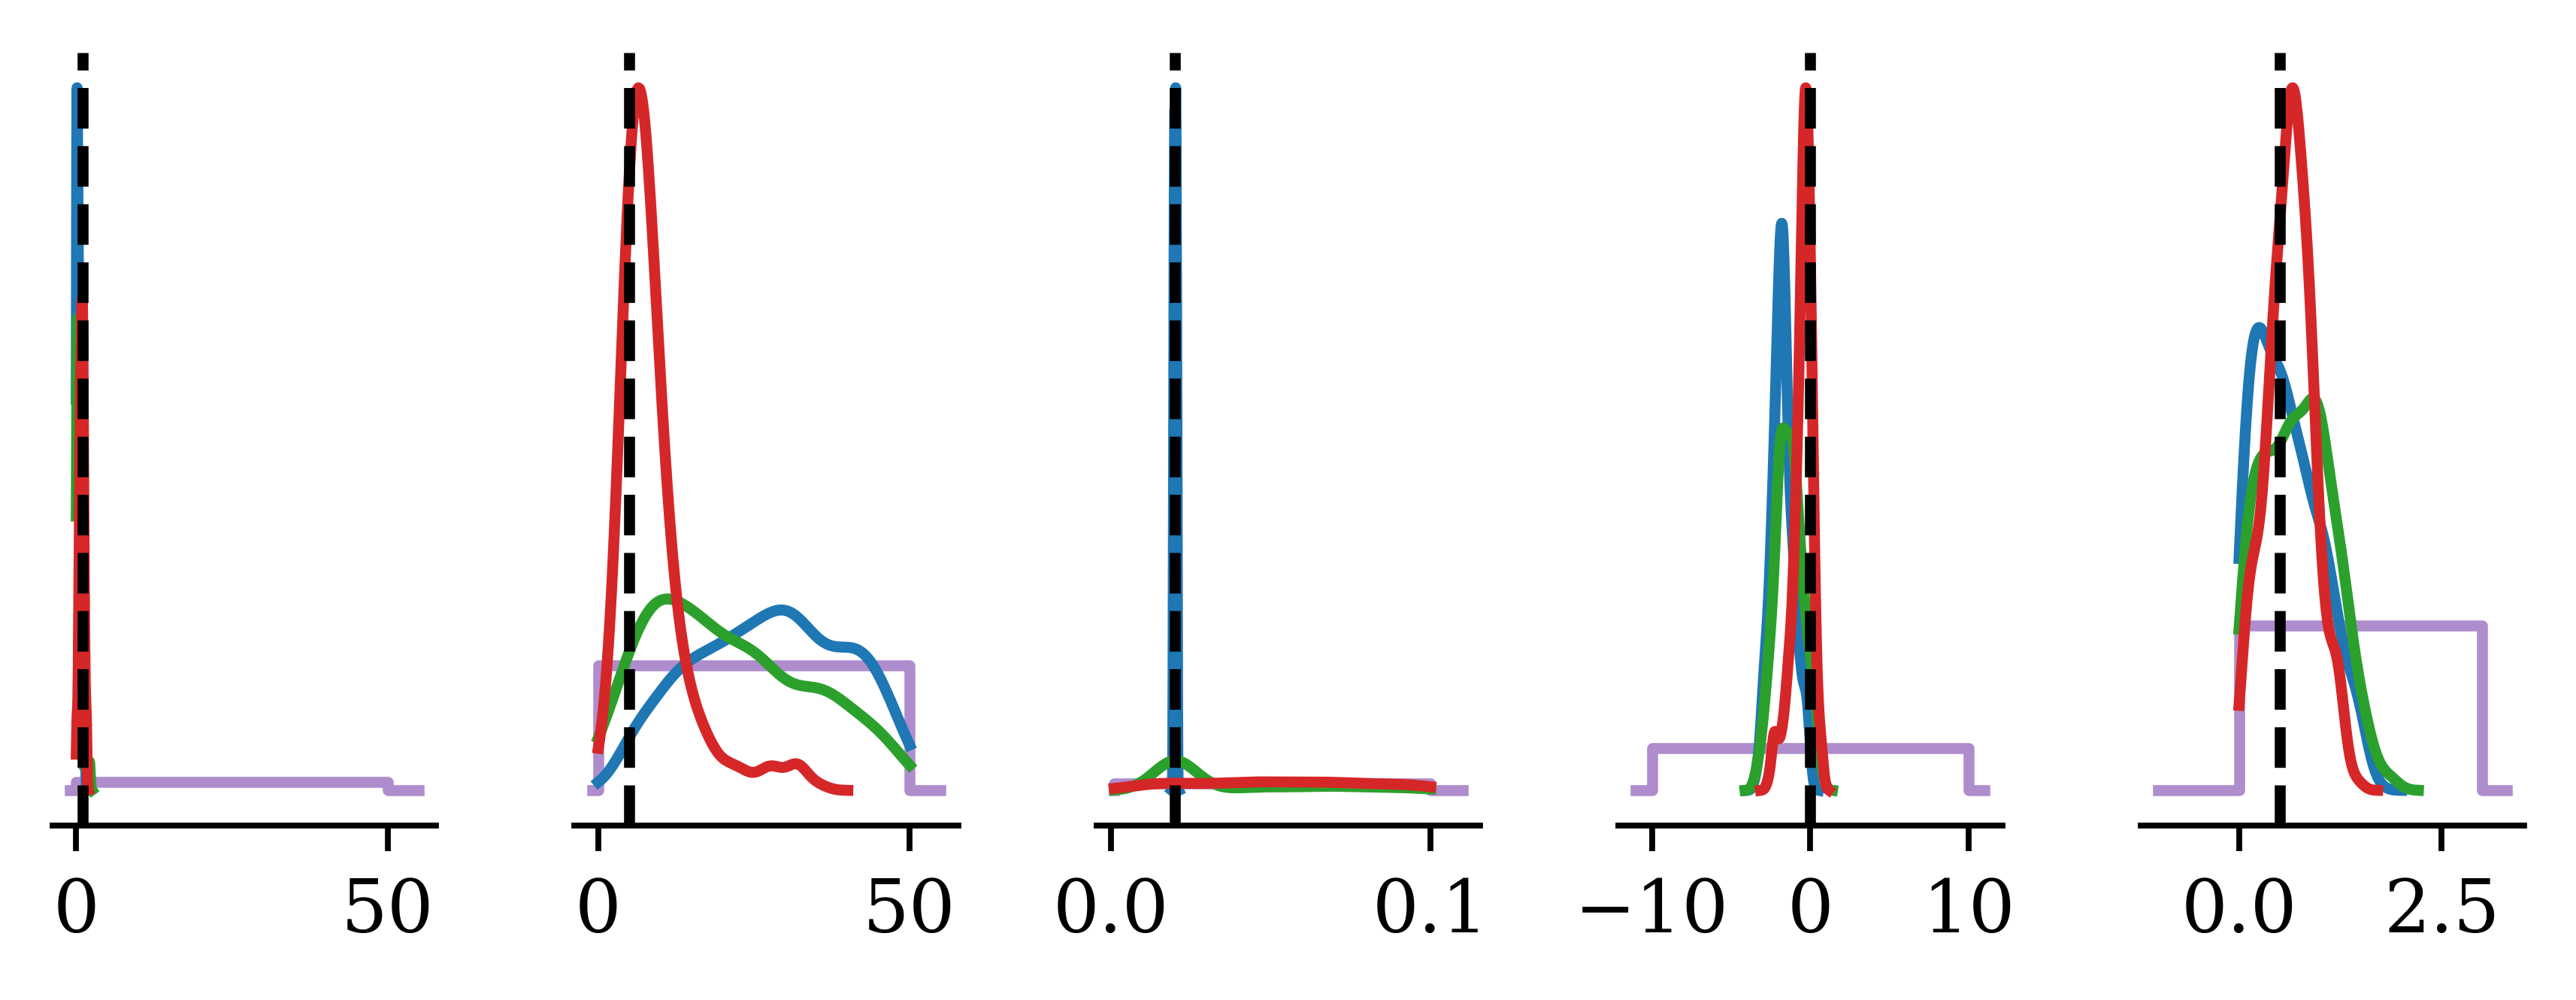

<Figure size 1750x700 with 0 Axes>

In [9]:
for ss in sample_sizes:

    fig, axs = plt.subplots(1, len(params), tight_layout=True)

    for l in range(len(params)):
        pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
        #         axs[l].set_xlim(pLims)

        for k, distance in enumerate(distances):
            sampleData = dfABC.query("distance == @distance").query("ss == @ss")
            sample = sampleData[params[l]]
            weights = sampleData["weights"]

            dataResampled, xs, ys = abc.resample_and_kde(sample, weights, clip=pLims)
            axs[l].plot(xs, ys, label=distance)

        axs[l].axvline(θ_True[l], **trueStyle)
        #     axs[l].set_title("$" + params[l] + "$")
        axs[l].set_yticks([])

    draw_prior(prior, axs)
    sns.despine(left=True)
    save_cropped("../Figures/hist-cyclical-poisson-lnorm-T" + str(ss) + ".pdf")
    plt.show()    

# Combining the L1 and L1 on sorted data posteriors

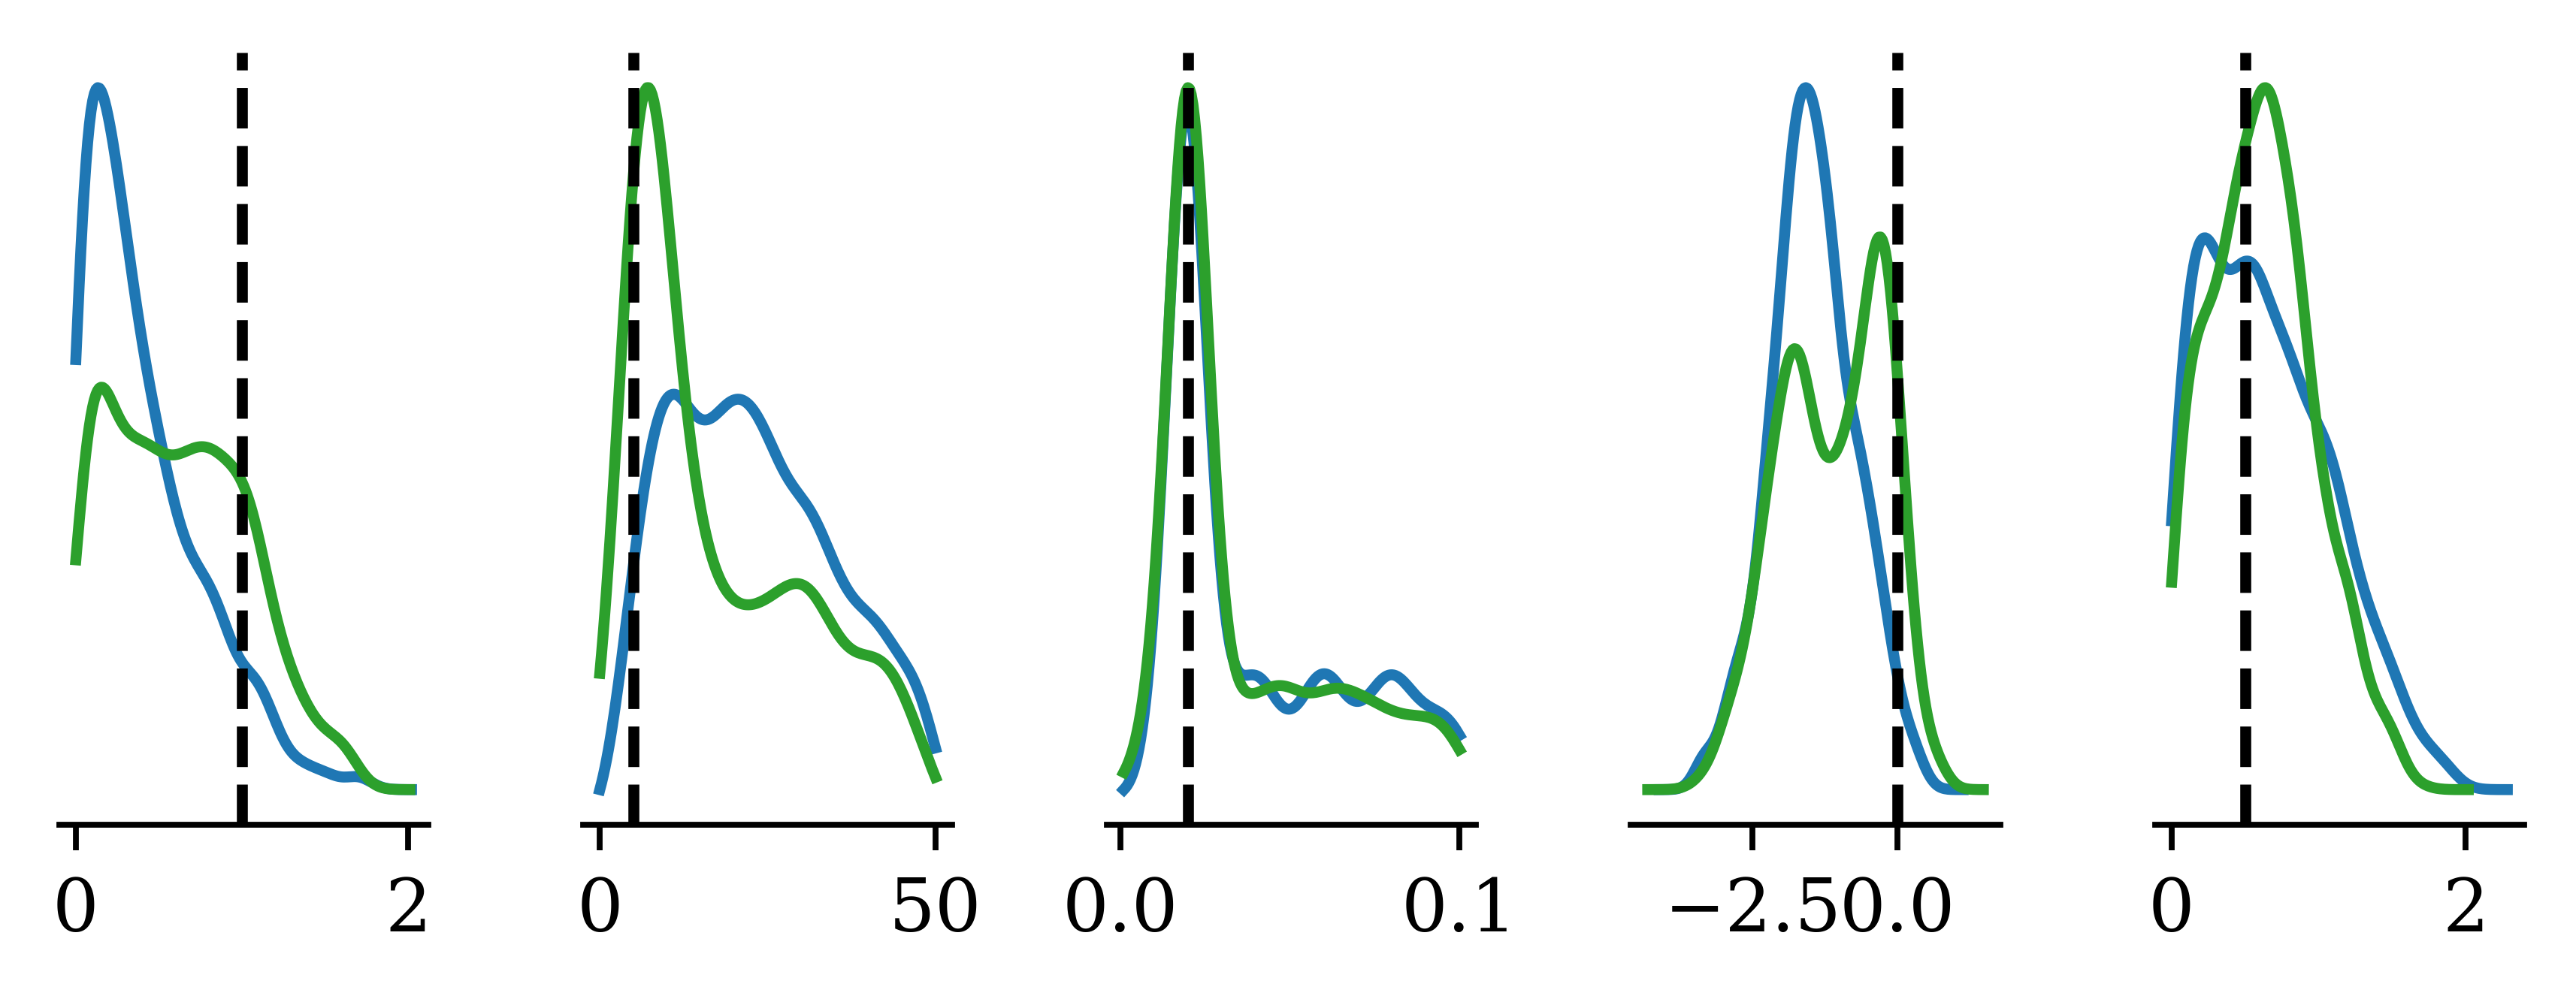

In [10]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)
dfABC_new = dfABC.iloc[
    np.array(dfABC.distance == "sorted_data") | np.array(dfABC.distance == "L1")
]

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
    # axs[l].set_xlim(pLims)

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC_new.query("ss == @ss")

        sample = sampleData[params[l]]

        weights = sampleData["weights"]

        dataResampled, xs, ys = abc.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label=str(ss))

    axs[l].axvline(θ_True[l], **trueStyle)
    #     axs[l].set_title("$" + params[l] + "$")
    axs[l].set_yticks([])


# draw_prior(prior, axs)
sns.despine(left=True)
# save_cropped("../Figures/hist-cyclical-poisson-lnorm-post_combination.pdf")

# Plots to compare the posterior distribution based on a specifi distance with different sample size

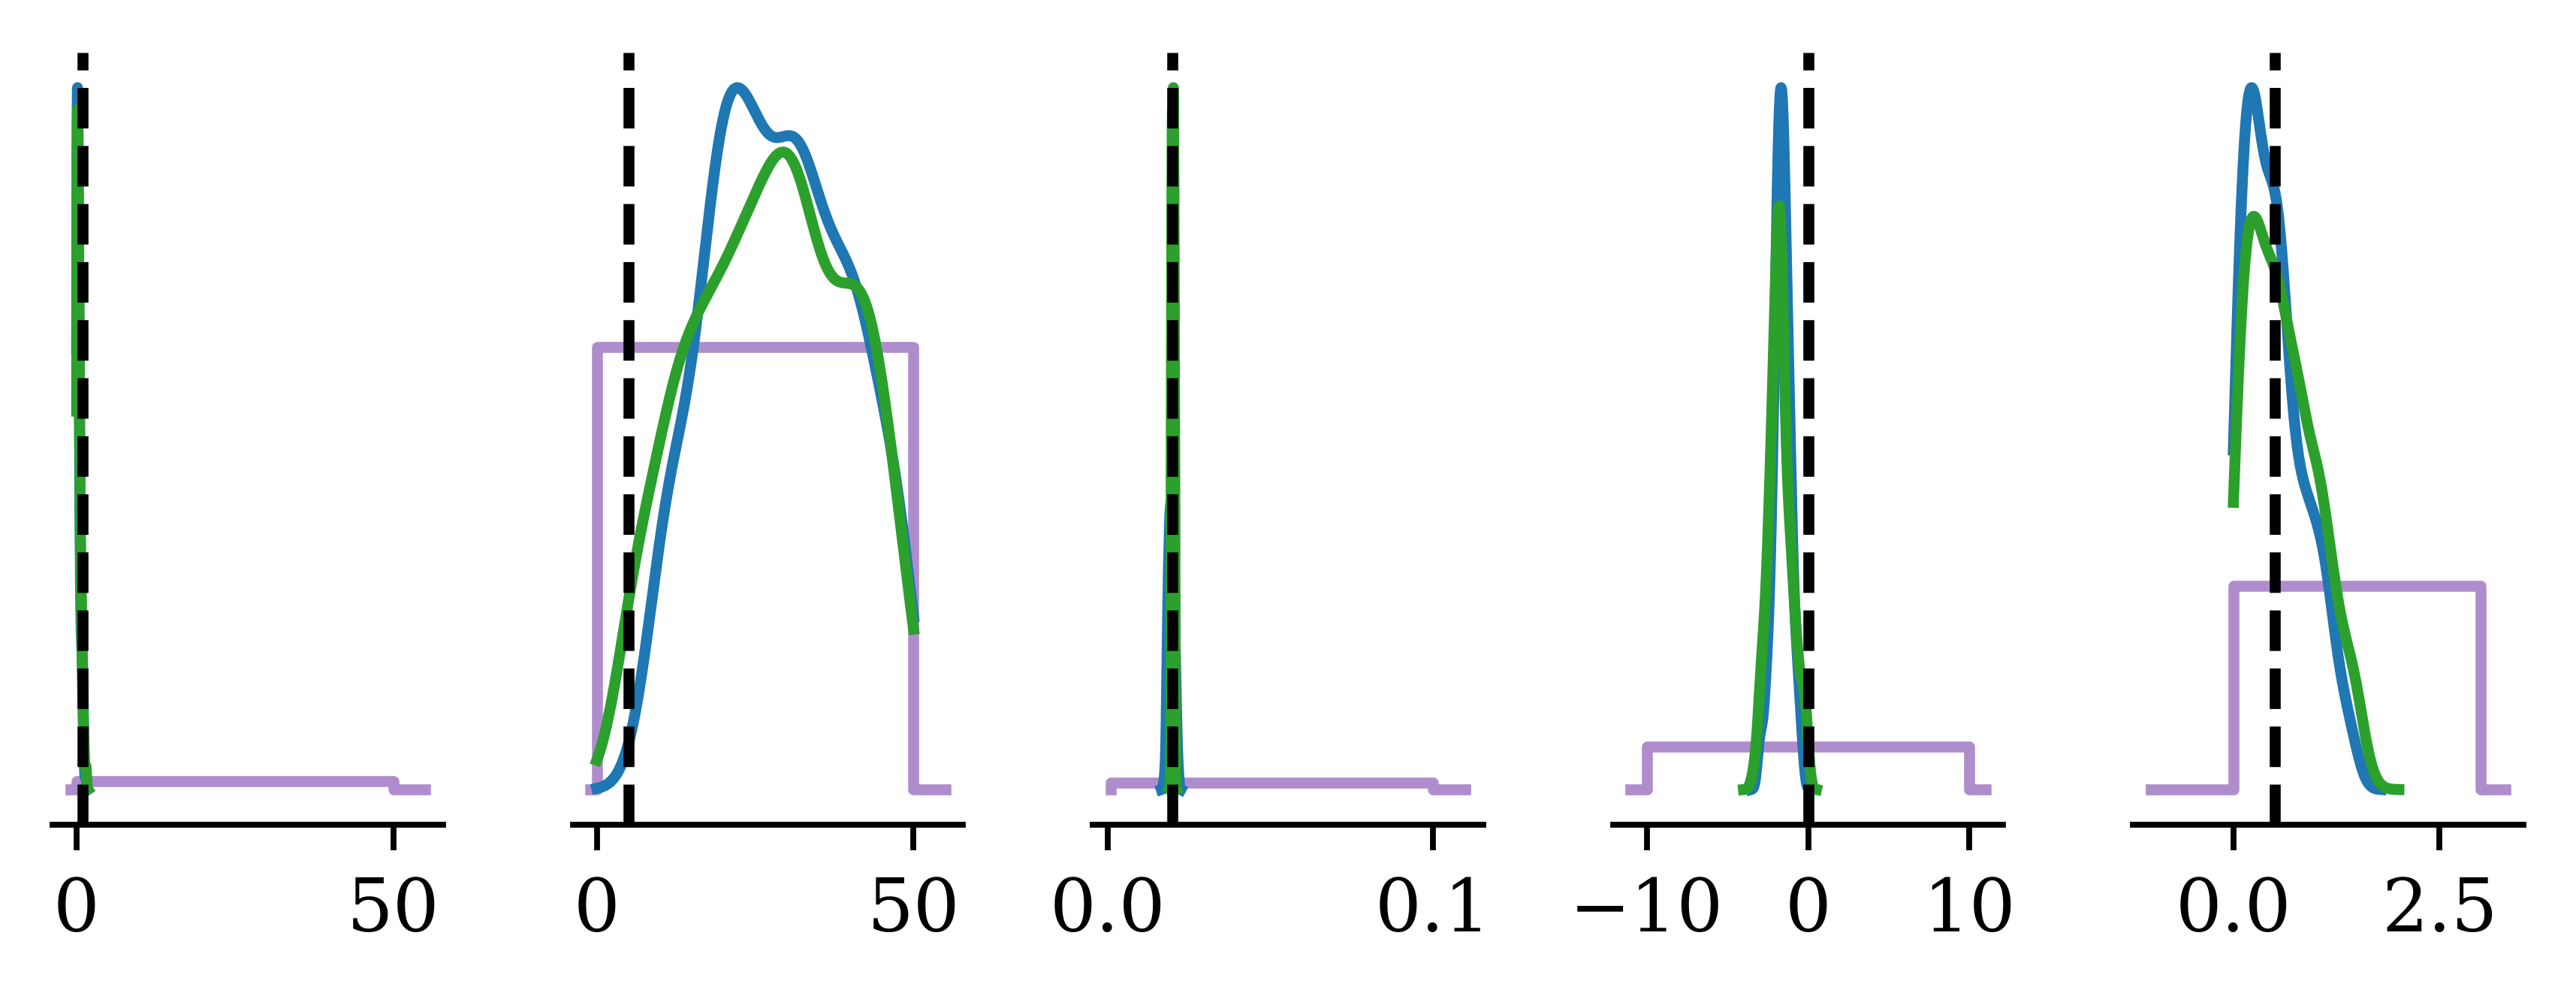

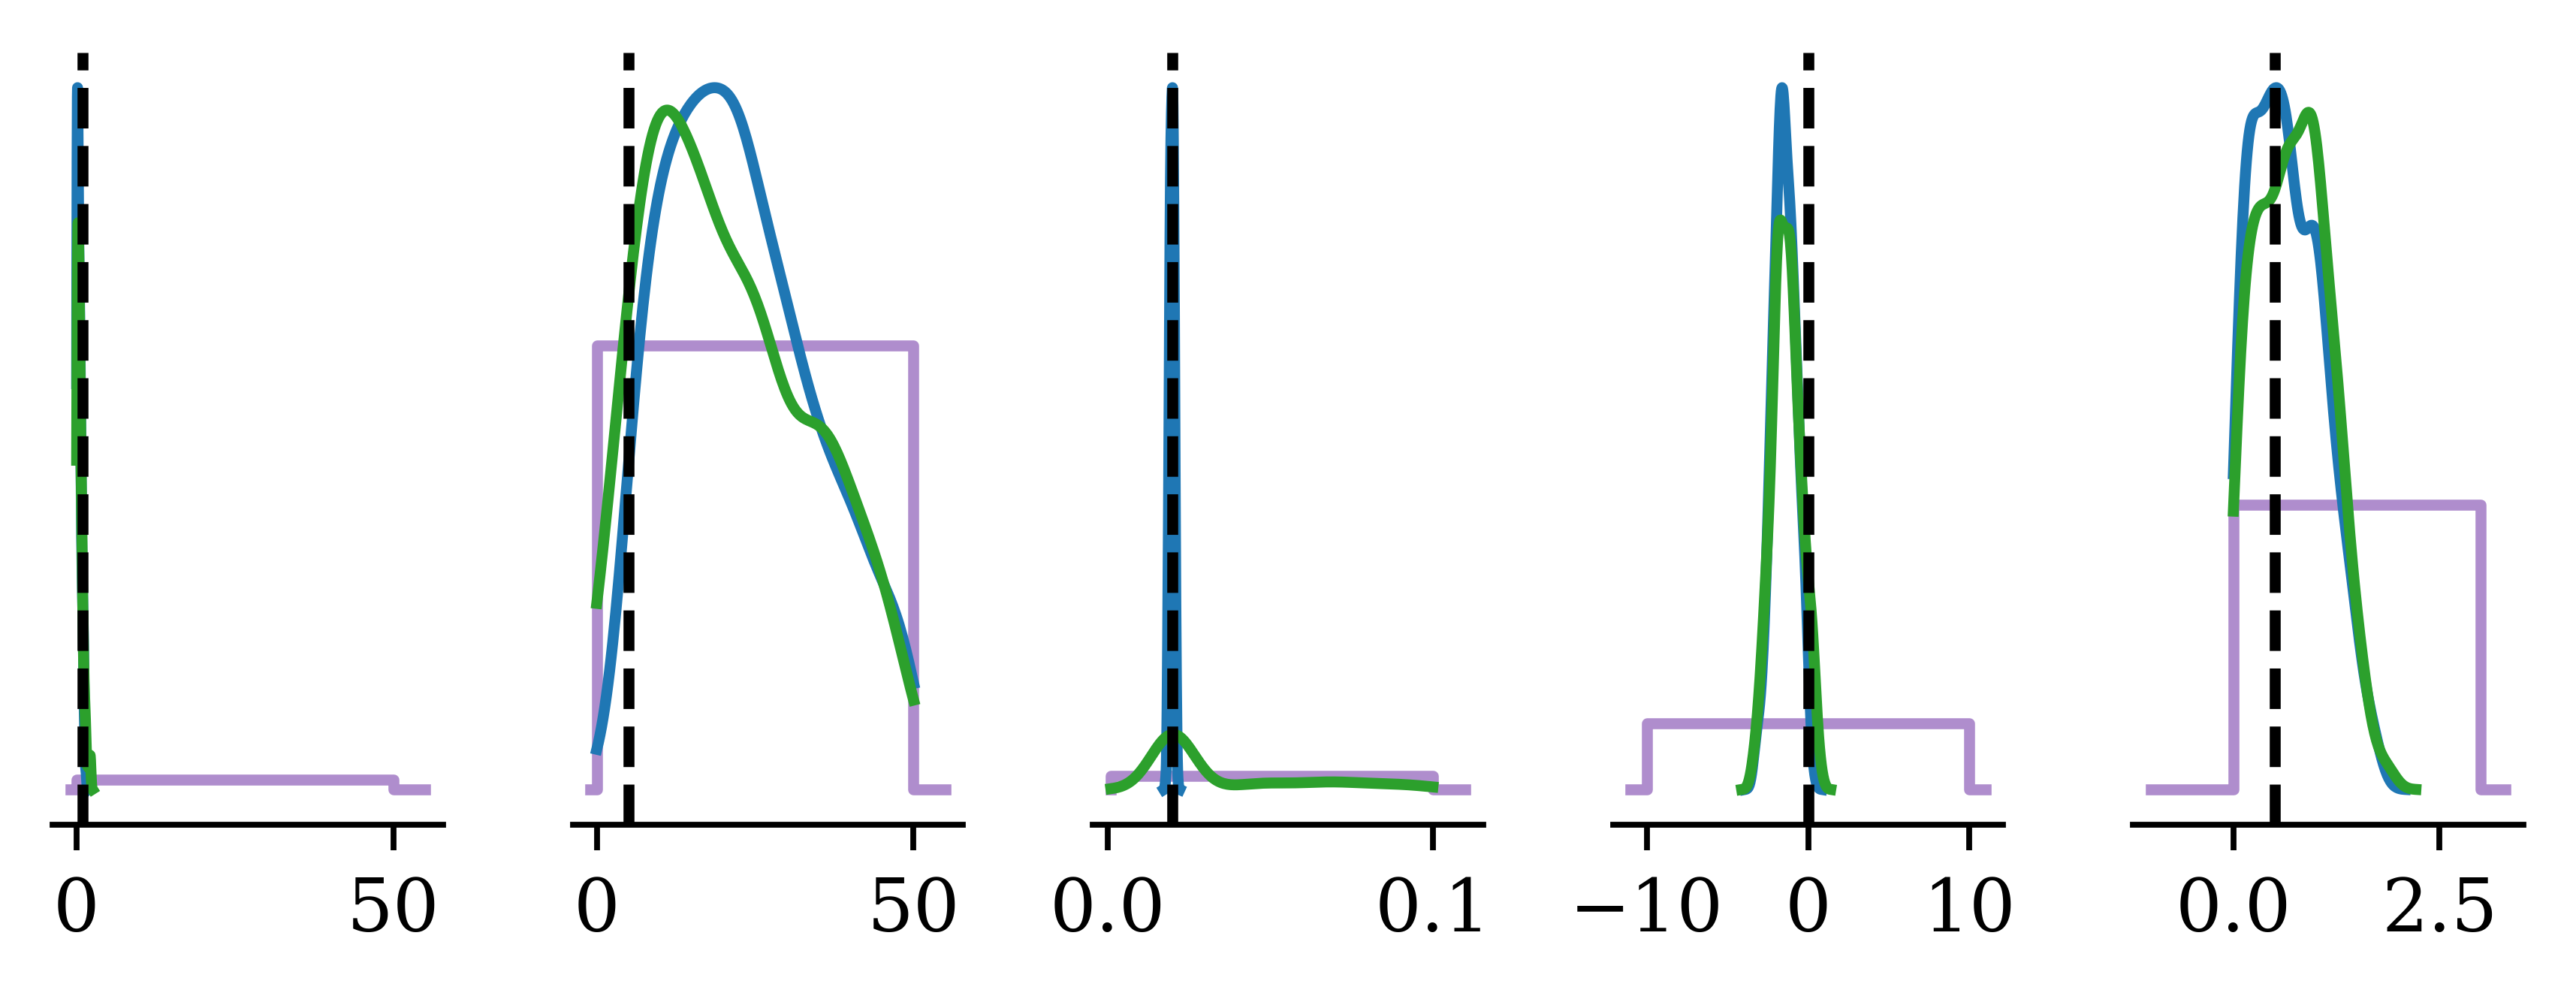

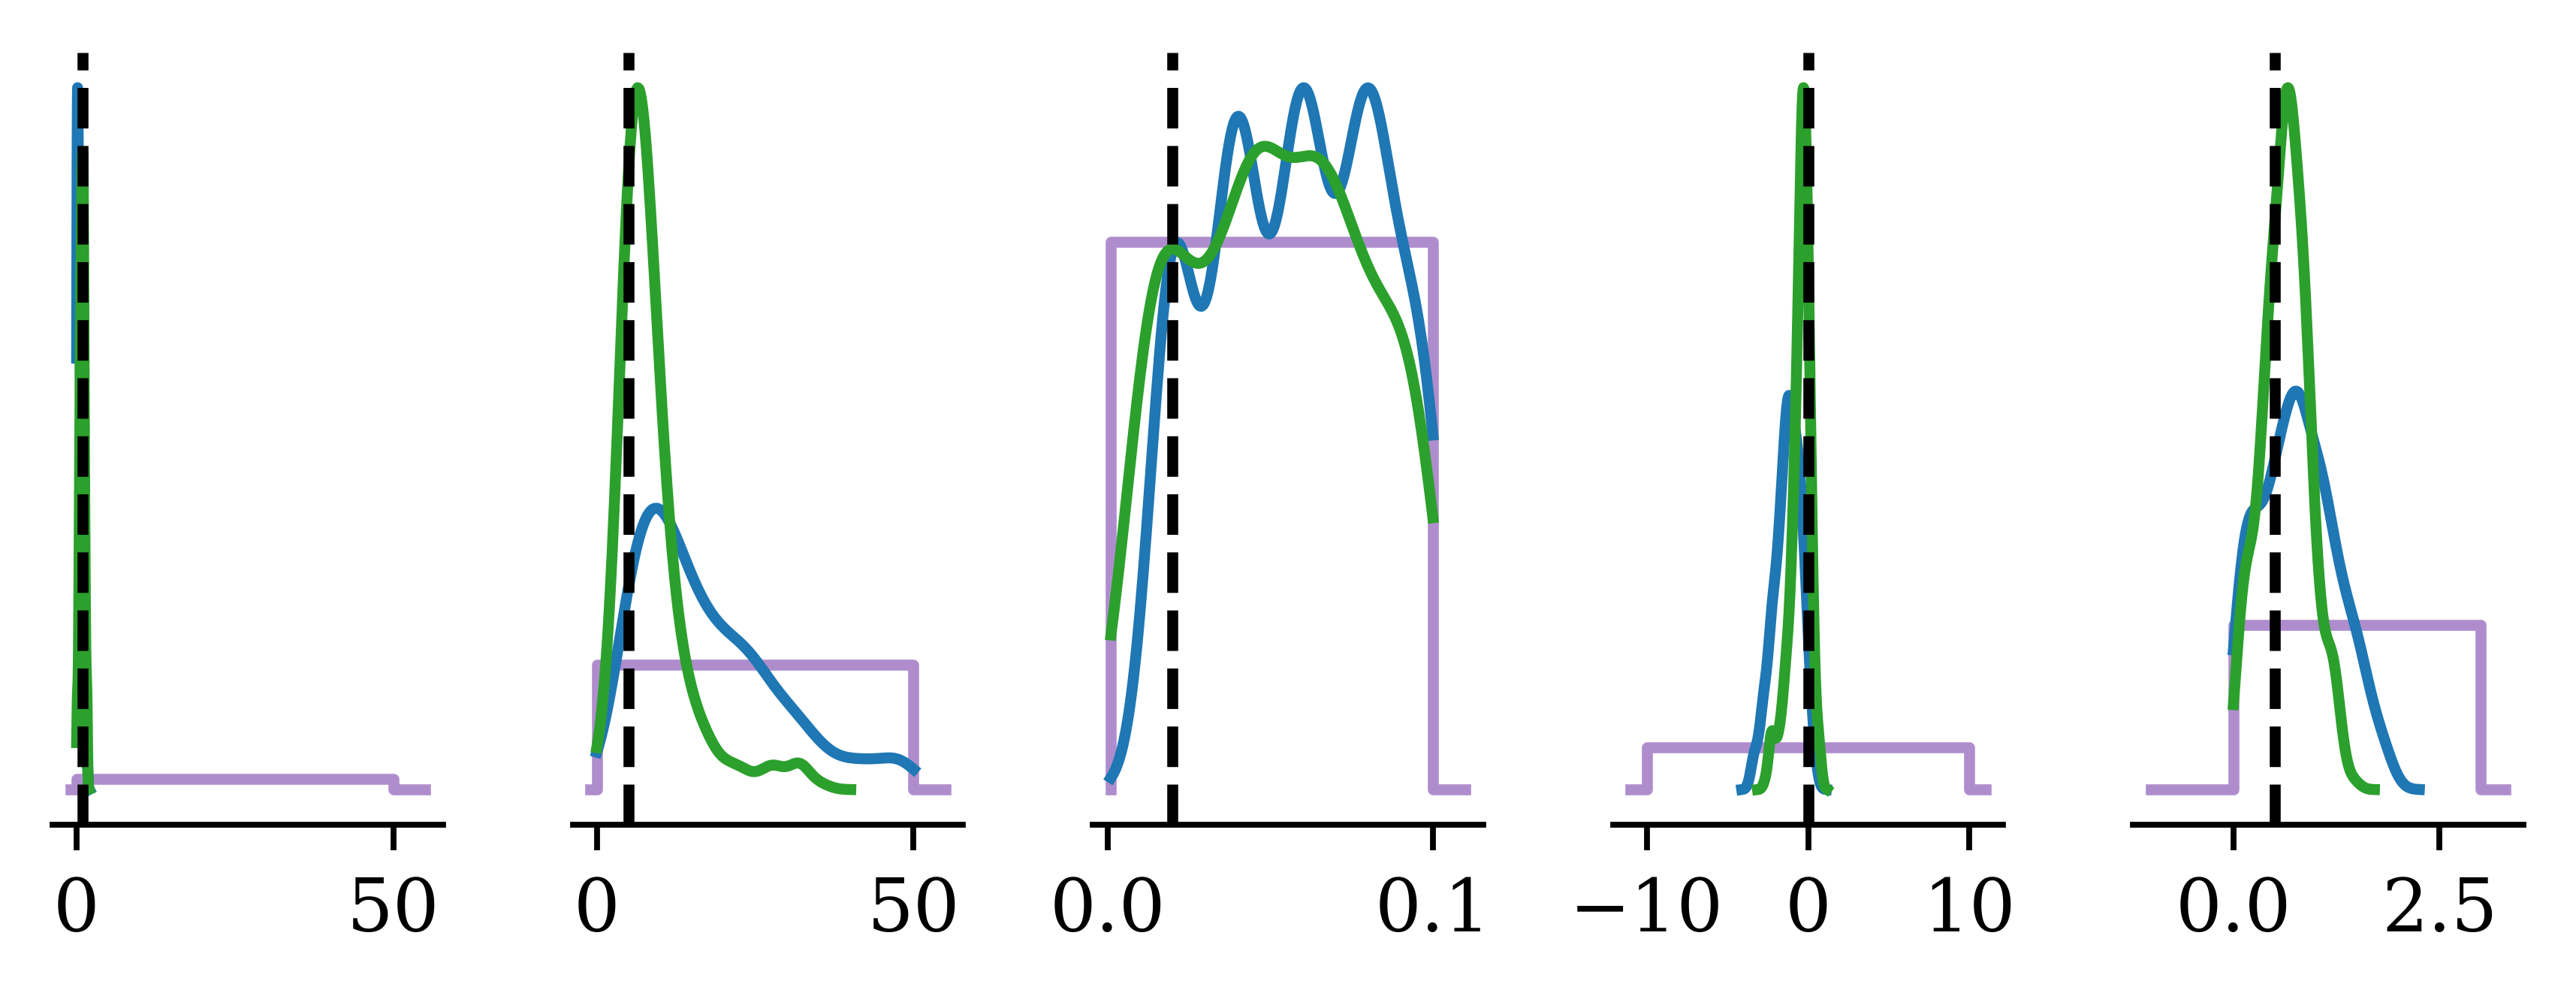

In [11]:
for distance in distances:
    # distance = "L1"
    fig, axs = plt.subplots(1, len(params), tight_layout=True)

    for l in range(len(params)):
        pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
        # axs[l].set_xlim(pLims)

        for k, ss in enumerate(sample_sizes):
            sampleData = dfABC.query("ss == @ss").query("distance == @distance")
            sample = sampleData[params[l]]

            weights = sampleData["weights"]

            dataResampled, xs, ys = abc.resample_and_kde(sample, weights, clip=pLims)
            axs[l].plot(xs, ys, label=str(ss))

        axs[l].axvline(θ_True[l], **trueStyle)
        #     axs[l].set_title("$" + params[l] + "$")
        axs[l].set_yticks([])

    #     handles, labels = axs[0].get_legend_handles_labels()
    #     fig.legend(
    #         handles, labels, ncol=3, borderaxespad=0.0, loc="upper center", frameon=False
    #     )
    draw_prior(prior, axs)
    sns.despine(left=True)
    #     plt.show()
    save_cropped("../Figures/hist-cyclical-poisson-lnorm-" + str(distance) + ".pdf")

# Recovered signal based on MAP estimators of the model parameters for a given sample size and a given distance

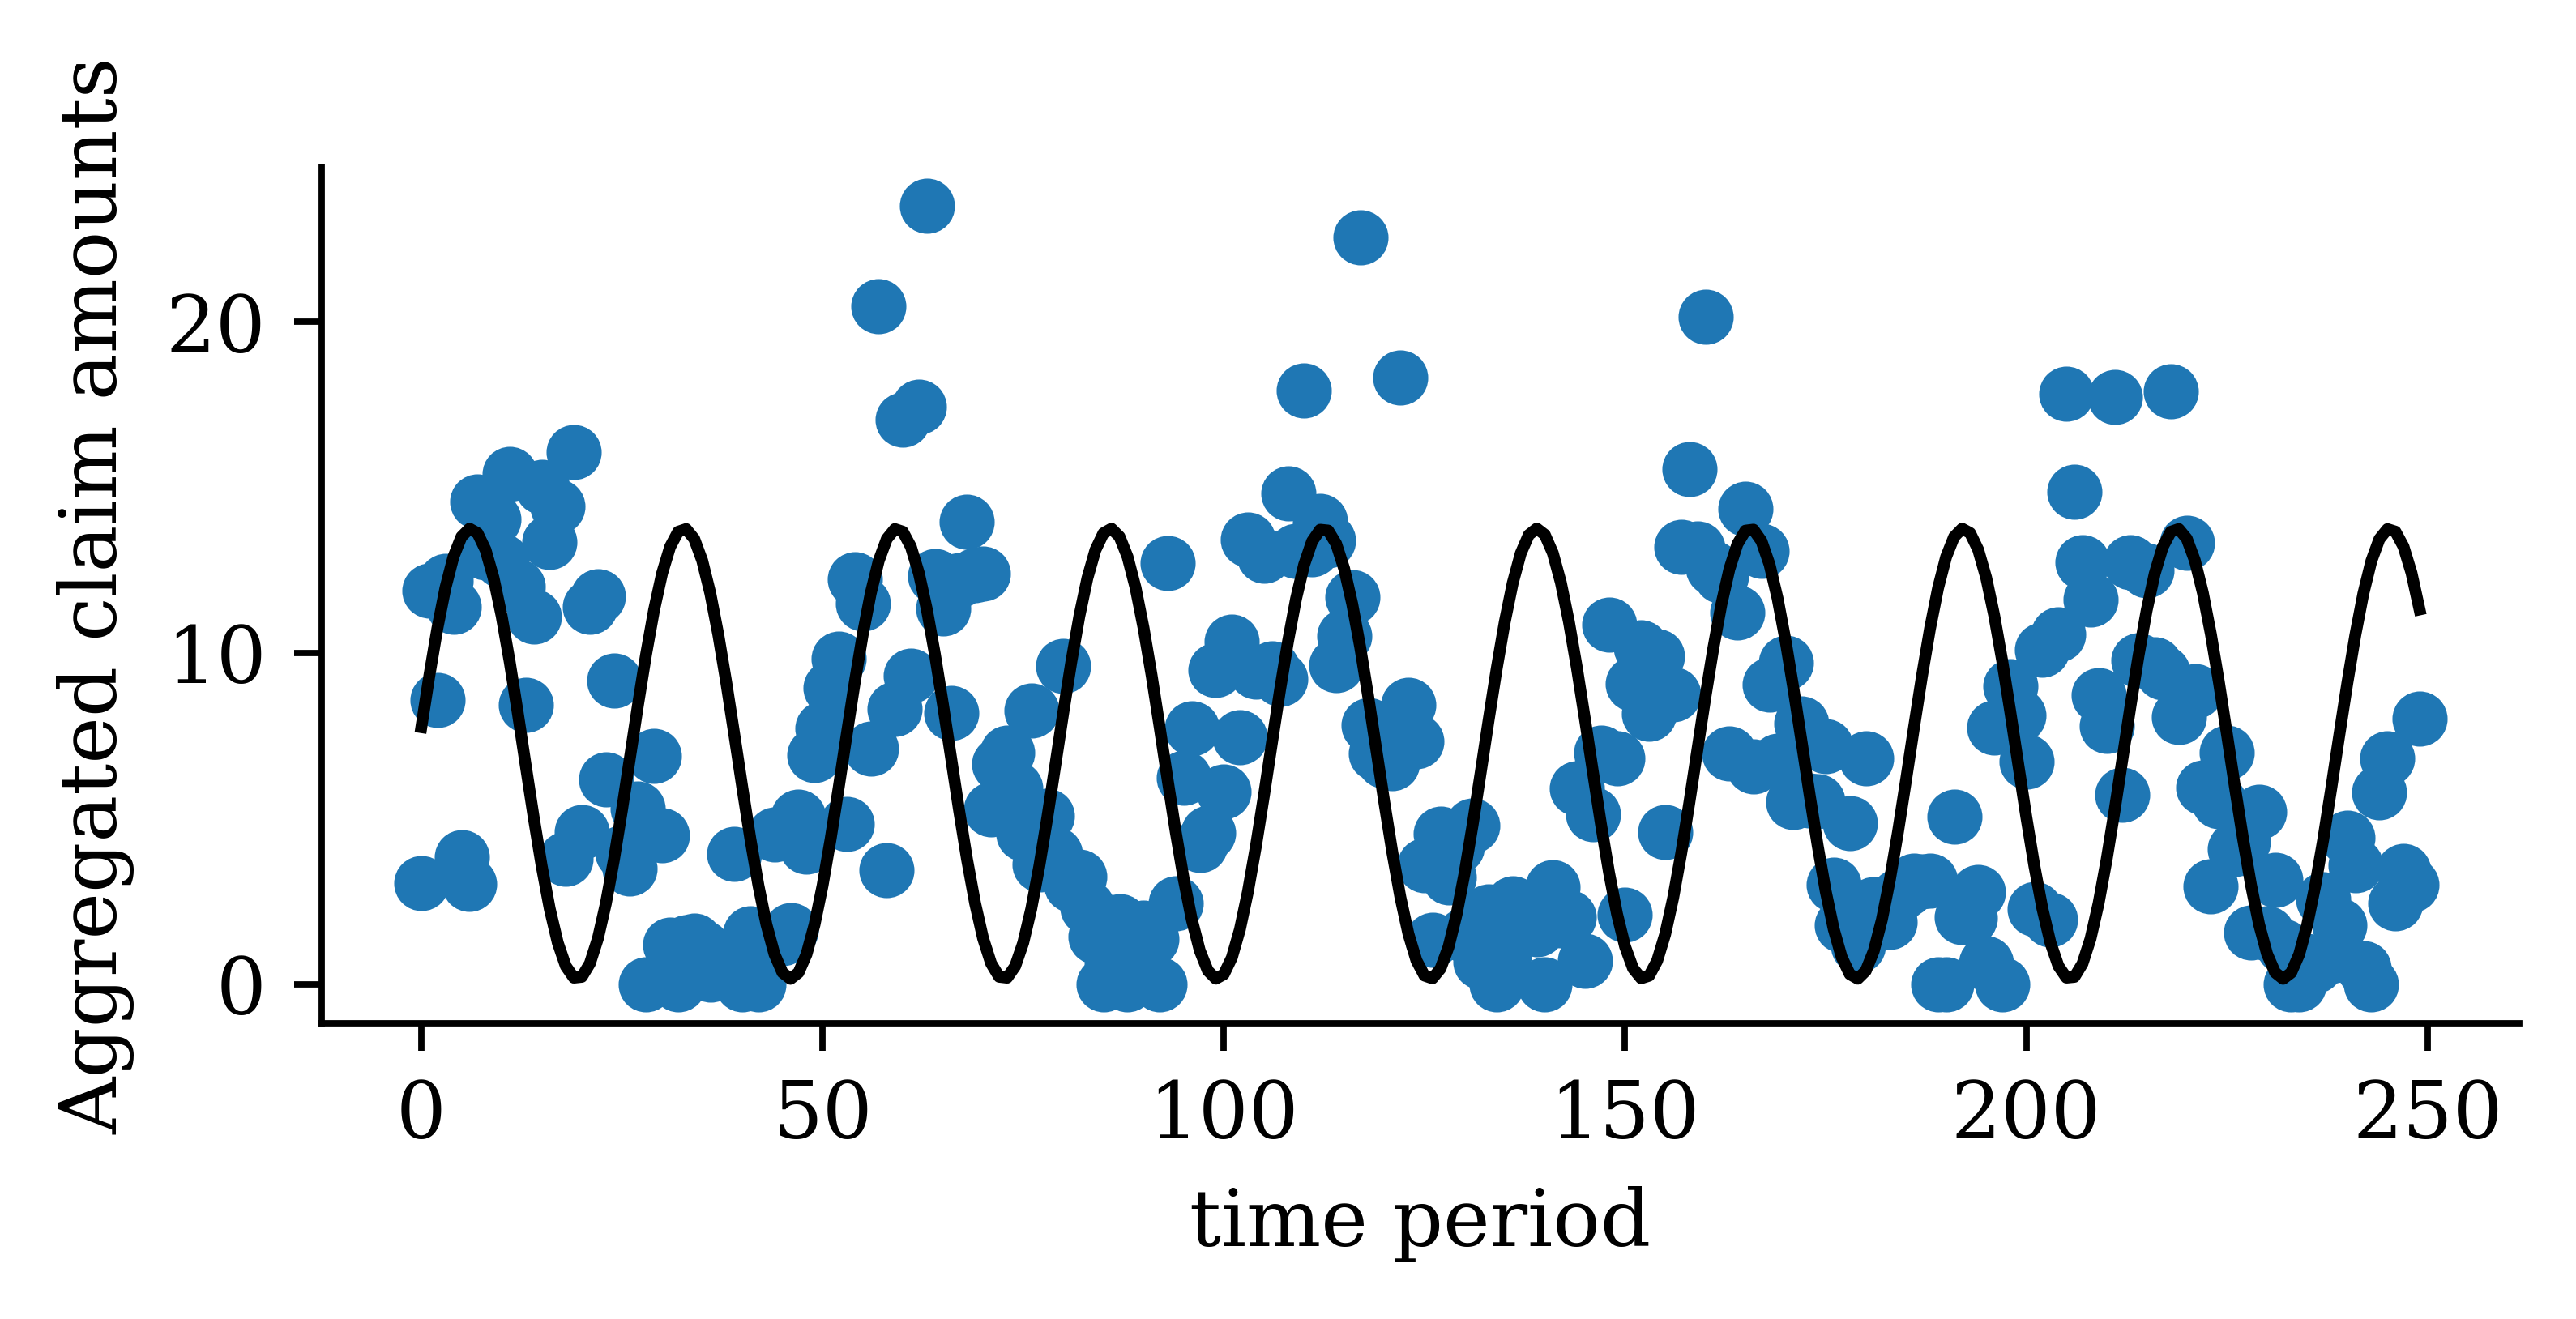

In [12]:
distance = "curve_matching"
ss = sample_sizes[1]
parms_name = ["a", "b", "c", "\mu", "\sigma"]
θ_map = (
    dfABC.query("ss == @ss").query("distance == @distance")[parms_name].mean().values
)
a, b, c, μ, σ = θ_map
t = np.arange(ss)
mus = (
    a
    + b
    + b * (np.cos(2 * np.pi * t * c) - np.cos(2 * np.pi * (t + 1) * c)) / 2 / np.pi / c
)
expXs = np.exp(μ + σ ** 2 / 2) * mus
# expXs = μ * mus
fig, ax = plt.subplots()
ax.plot(t, expXs, label="Expected value for X_s", c="k")
ax.scatter(t, xData[:ss])
ax.set(xlabel="time period", ylabel="Aggregated claim amounts", title="")
# ax.grid()
sns.despine()

In [13]:
elapsed = toc()
print(f"Notebook time = {elapsed:.0f} secs = {elapsed/60:.2f} mins")

Notebook time = 459 secs = 7.65 mins


In [14]:
dill.dump_session("Sim_Cyclical_Poisson.pkl")